# Logistische Regression

Wir werden in diese Vorlesung mit dem [Titanic Datensatz](https://www.kaggle.com/c/titanic) von Kaggle arbeiten. Dieser Datensatz ist weit verbreitet und sehr gängig beim Erlernen von Maschine Learning. Wir werden versuchen eine Klassifikation vorherzusehen - überlebender oder verstorbener Passagier.

Beginnen wir mit dem Verständnis der Implementierung der Logistischen Regression in R für Klassifikationen. 

Wir benutzen hierbei die "semi-cleaned" Version des Titanic Datensatzes. Wenn ihr den Datensatz der auf der Kaggle Seite gehostet wird benutzt, müsst ihr diesen eventuell noch ein wenig bereinigen. 
*Dieser Schritt wird in dieser Vorlesung nicht gezeigt.*


## Der Datensatz

Wir beginnen mit dem Laden unserer Übungsdaten in die Data Frames.

In [1]:
df.train <- read.csv('titanic_train.csv')

In [2]:
head(df.train)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


# Explorative Daten Analyse (EDA)

Zuerst untersuchen wir wie viele Daten uns fehlen. Wir benutzen hierfür das Amelia Paket. Wenn ihr möchtet könnt ihr es jetzt schon installieren, um der Aufgabe besser zu folgen. Spätestens für das Logistische Regressions Projekt  werdet ihr es installieren müssen.

In [3]:
# install.packages("Amelia")

Loading required package: Rcpp
Warning message in as.POSIXlt.POSIXct(x, tz):
“unknown timezone 'zone/tz/2018c.1.0/zoneinfo/Europe/Berlin'”## 
## Amelia II: Multiple Imputation
## (Version 1.7.4, built: 2015-12-05)
## Copyright (C) 2005-2018 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 


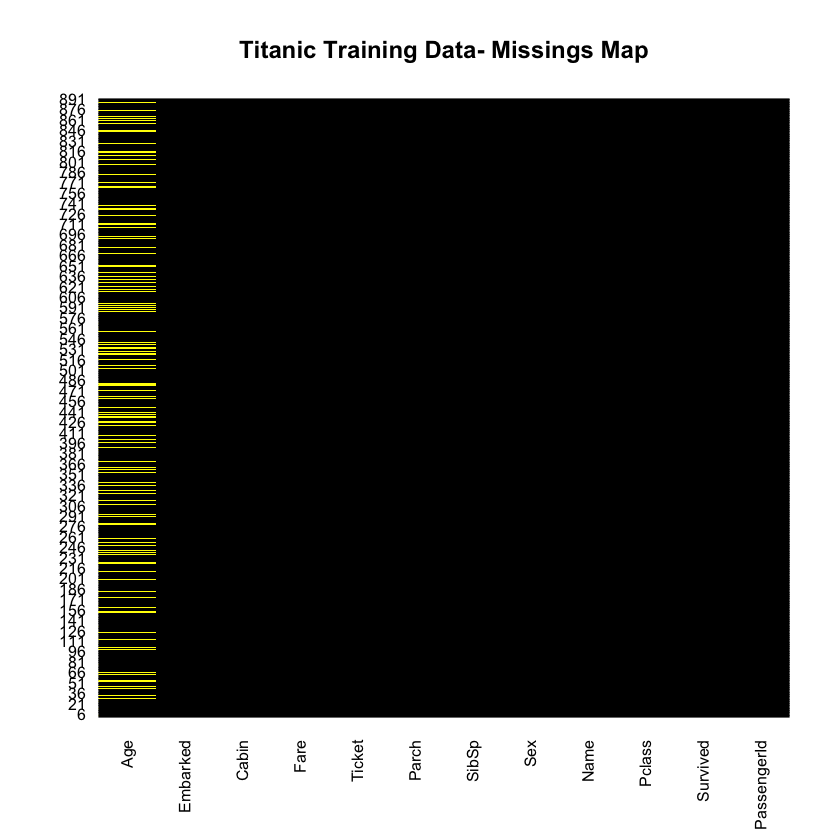

In [4]:
library(Amelia)
missmap(df.train, main="Titanic Training Data- Missings Map", 
        col=c("yellow", "black"), legend=FALSE)

Der Anteil an fehlenden Age-Einträgen ist wahrscheinlich klein genug, um eine sinnvolle Ersetzung durch Einfügen von Werten vorzunehmen.

Jetzt werden wir ausgewählte Daten visualisieren.

## Daten Visualisierung mit ggplot2

In [5]:
library(ggplot2)

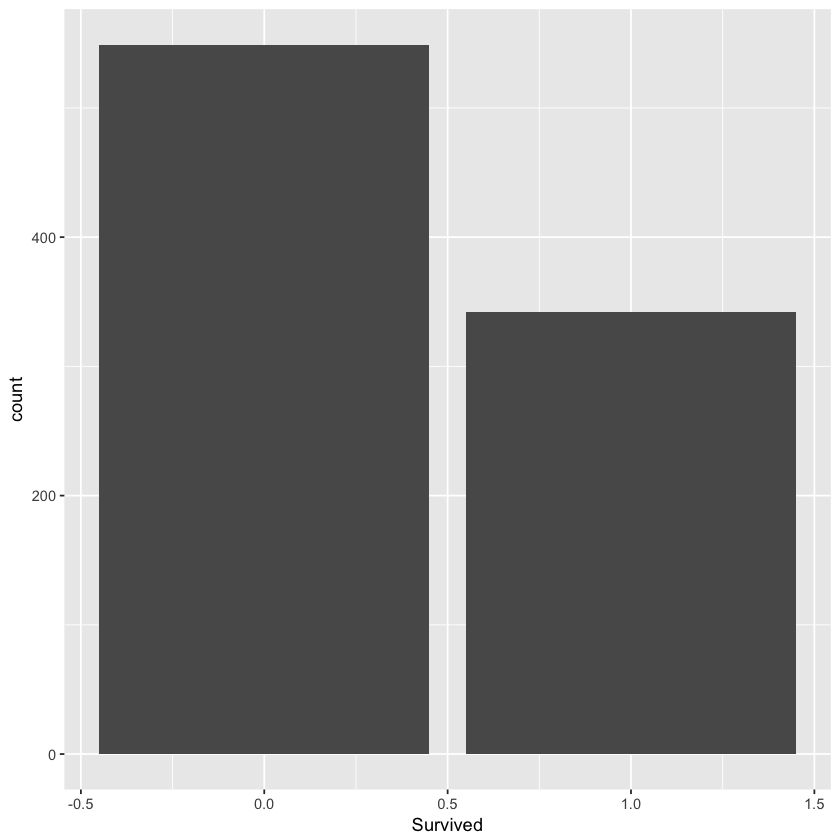

In [6]:
ggplot(df.train,aes(Survived)) + geom_bar()

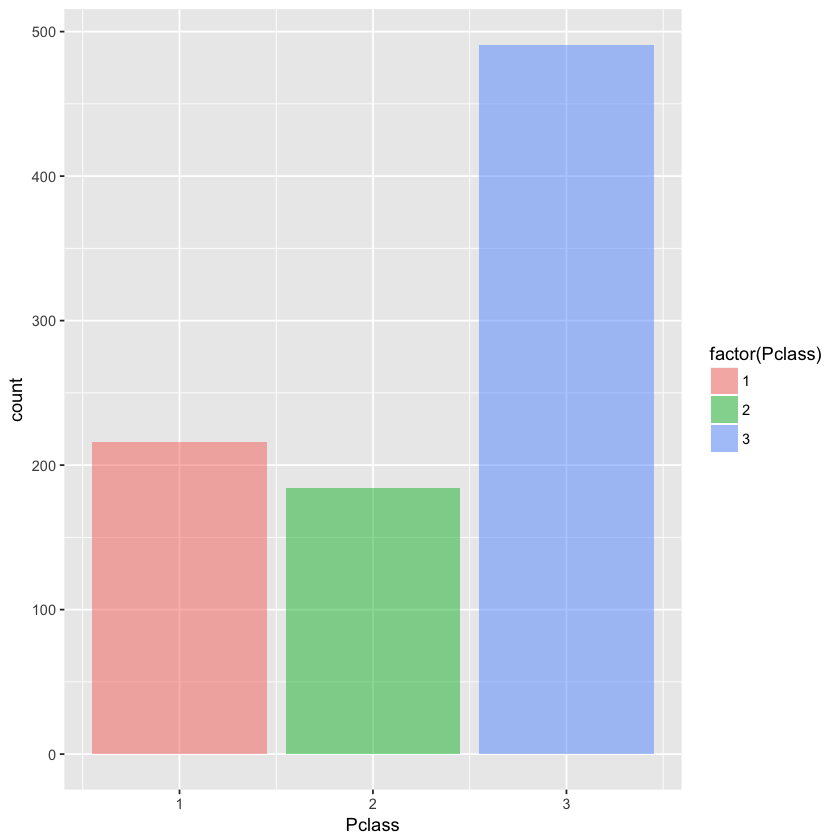

In [7]:
ggplot(df.train,aes(Pclass)) + geom_bar(aes(fill=factor(Pclass)),alpha=0.5)

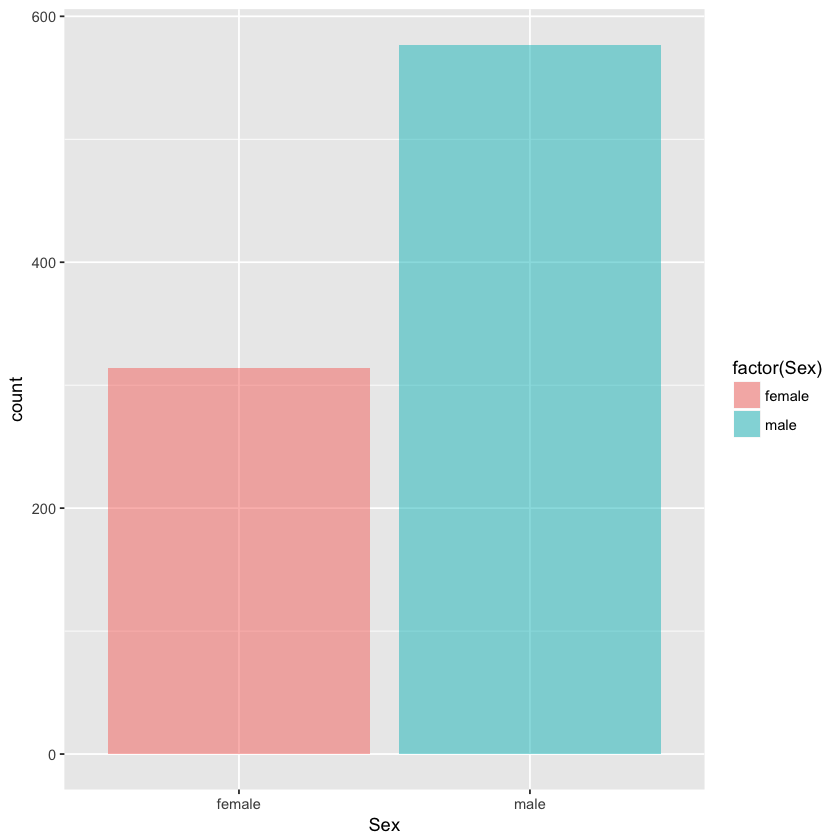

In [8]:
ggplot(df.train,aes(Sex)) + geom_bar(aes(fill=factor(Sex)),alpha=0.5)

Warning message:
“Removed 177 rows containing non-finite values (stat_bin).”

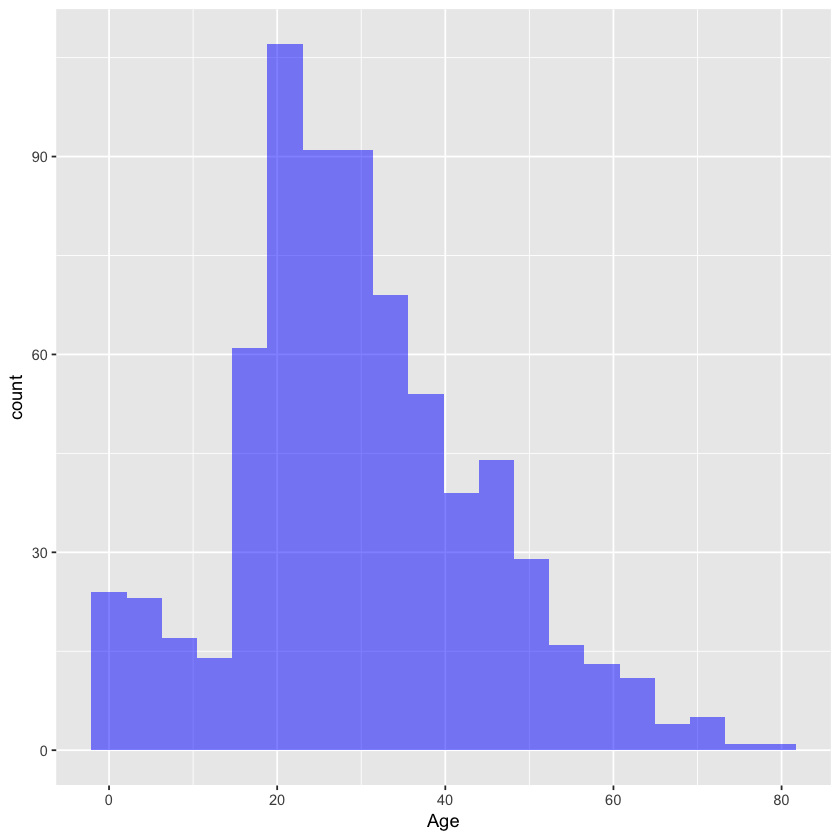

In [9]:
ggplot(df.train,aes(Age)) + geom_histogram(fill='blue',bins=20,alpha=0.5)

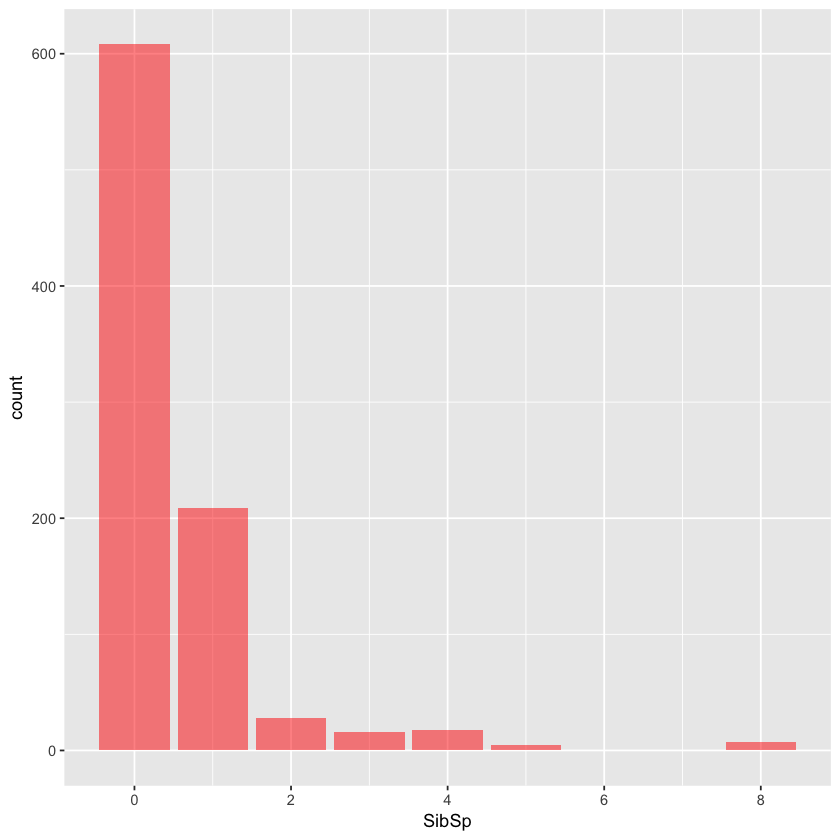

In [10]:
ggplot(df.train,aes(SibSp)) + geom_bar(fill='red',alpha=0.5)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


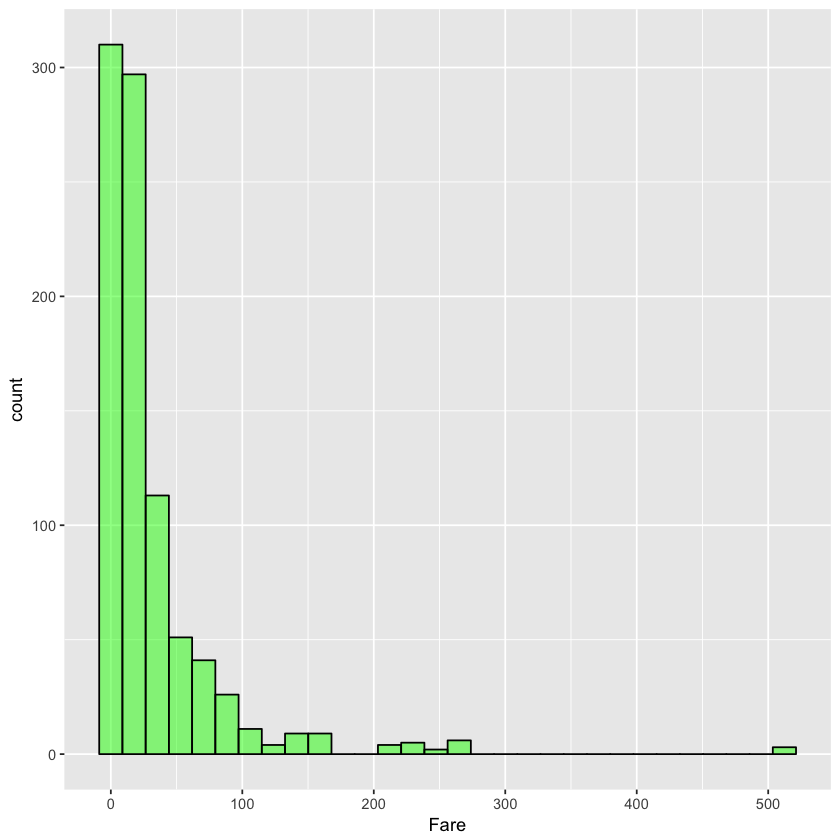

In [11]:
ggplot(df.train,aes(Fare)) + geom_histogram(fill='green',color='black',alpha=0.5)

# Datensatz bereinigen 

Wir möchten fehlende Altersdaten einfügen anstatt jeweils die ganze Zeile zu löschen.
Eine Art und Wiese dies zu tun ist das Durchschnittsalter aller Passagiere dort einzufügen (Imputation).

Allerdings können wir noch ein wenig schlauer sein und das Durchschnittsalter der Passagiere pro Klasse überprüfen. 
Zum Beispiel:

Warning message:
“Removed 177 rows containing non-finite values (stat_boxplot).”

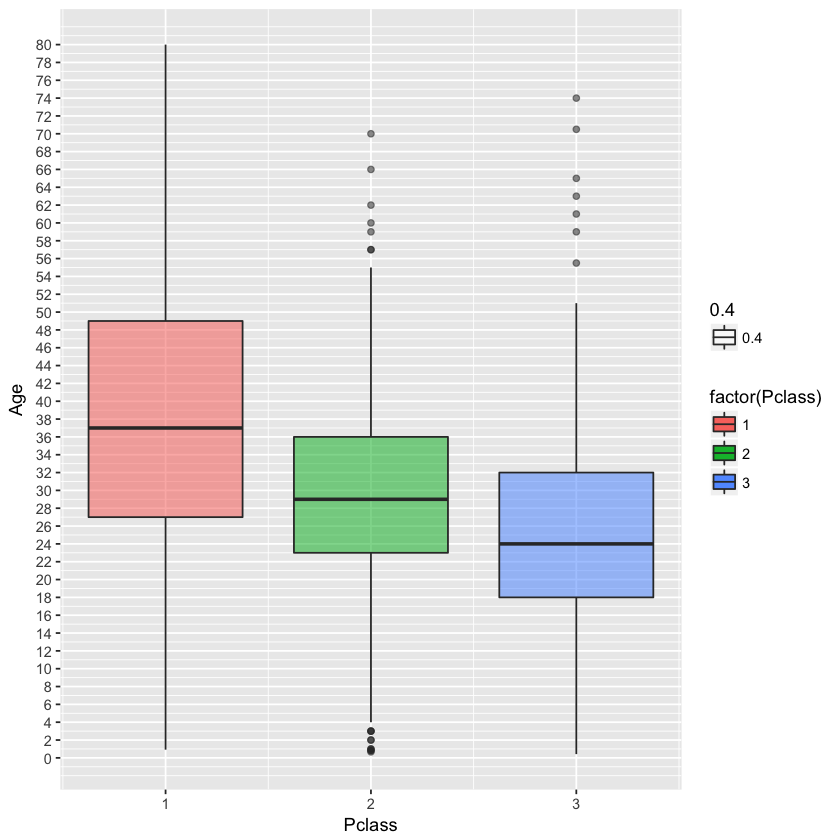

In [12]:
pl <- ggplot(df.train,aes(Pclass,Age)) + geom_boxplot(aes(group=Pclass,fill=factor(Pclass),alpha=0.4)) 
pl + scale_y_continuous(breaks = seq(min(0), max(80), by = 2))

Wir können jetzt sehen, dass die wohlhabenderen Passagiere in den höheren Klassen eher älter sind, was ja auch Sinn ergibt. Wir benutzen diese Durchschnittsalter als Wert zum Einfügen basierend auf `Pclass` für das Alter. 

In [13]:
impute_age <- function(age,class){
    out <- age
    for (i in 1:length(age)){
        
        if (is.na(age[i])){

            if (class[i] == 1){
                out[i] <- 37

            }else if (class[i] == 2){
                out[i] <- 29

            }else{
                out[i] <- 24
            }
        }else{
            out[i]<-age[i]
        }
    }
    return(out)
}

In [14]:
fixed.ages <- impute_age(df.train$Age,df.train$Pclass)

In [15]:
df.train$Age <- fixed.ages

Lasst uns nun überprüfen ob es funktioniert hat: 

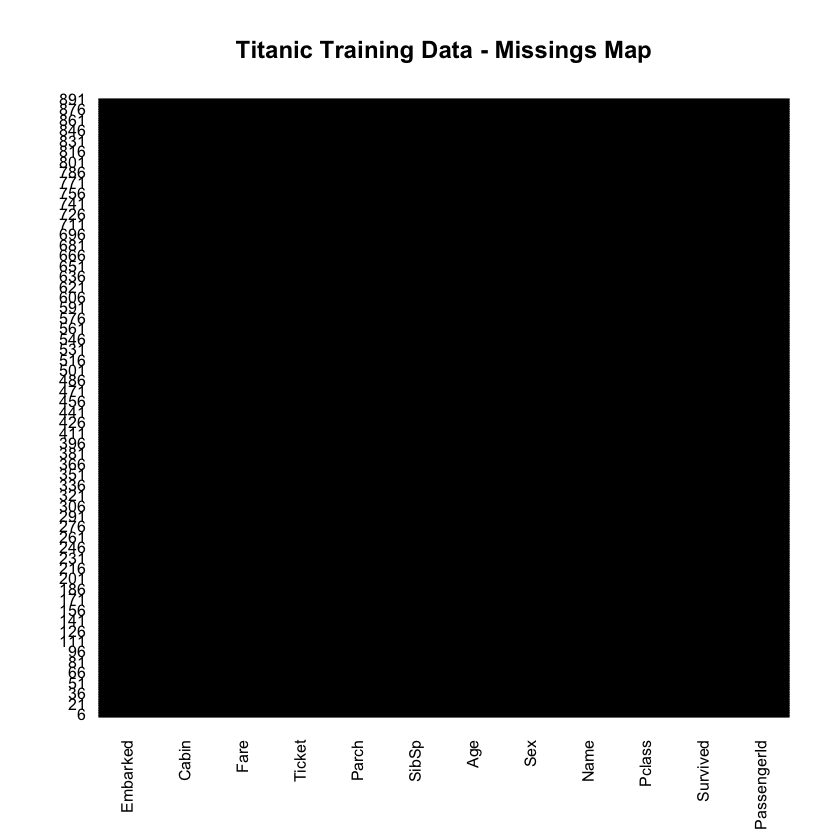

In [16]:
missmap(df.train, main="Titanic Training Data - Missings Map", 
        col=c("yellow", "black"), legend=FALSE)

Super! Lasst uns nun beginnen unser Model zu bauen. 

# Ein Logistisches Regressions Modell bauen

Nun ist es an der Zeit unser Modell zu bauen. Lasst uns damit beginnen einen finalen "Clean-up" unseres Datensatzes zu machen. Hierbei werden wir alle Daten entfernen, die wir nicht benutzen werden und noch mal sicherstellen, dass die Daten die wir benutzen den richtigen Datentypen haben.


In [17]:
str(df.train)

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 24 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


Jetzt entfernen wir die Datensätze die wir nicht benutzen:

In [18]:
head(df.train,3)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S


Jetzt wählen wir die relevanten Zeilen für die Übung aus: 

In [19]:
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [20]:
df.train <- select(df.train,-PassengerId,-Name,-Ticket,-Cabin)

In [21]:
head(df.train,3)

Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22,1,0,7.2500,S
1,1,female,38,1,0,71.2833,C
1,3,female,26,0,0,7.9250,S


Und jetzt setzen wir die Spalten Faktoren:

In [22]:
str(df.train)

'data.frame':	891 obs. of  8 variables:
 $ Survived: int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass  : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Sex     : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age     : num  22 38 26 35 35 24 54 2 27 14 ...
 $ SibSp   : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch   : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare    : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked: Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


In [23]:
df.train$Survived <- factor(df.train$Survived)
df.train$Pclass <- factor(df.train$Pclass)
df.train$Parch <- factor(df.train$Parch)
df.train$SibSp <- factor(df.train$SibSp)

## Das Modell trainieren

Lasst uns nun beginnen das Modell zu trainieren:

In [24]:
log.model <- glm(formula=Survived ~ . , family = binomial(link='logit'),data = df.train)

In [25]:
summary(log.model)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = df.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8158  -0.6134  -0.4138   0.5808   2.4896  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.845e+01  1.660e+03   0.011 0.991134    
Pclass2     -1.079e+00  3.092e-01  -3.490 0.000484 ***
Pclass3     -2.191e+00  3.161e-01  -6.930 4.20e-12 ***
Sexmale     -2.677e+00  2.040e-01 -13.123  < 2e-16 ***
Age         -3.971e-02  8.758e-03  -4.534 5.79e-06 ***
SibSp1       8.135e-02  2.245e-01   0.362 0.717133    
SibSp2      -2.897e-01  5.368e-01  -0.540 0.589361    
SibSp3      -2.241e+00  7.202e-01  -3.111 0.001862 ** 
SibSp4      -1.675e+00  7.620e-01  -2.198 0.027954 *  
SibSp5      -1.595e+01  9.588e+02  -0.017 0.986731    
SibSp8      -1.607e+01  7.578e+02  -0.021 0.983077    
Parch1       3.741e-01  2.895e-01   1.292 0.196213    
Parch2       3.862e-02  3.824e-01   0.101 0.919560    
Parch3   

Wir können nun sehen, dass "Sex" (Geschlecht), "Age" (Alter) und "Class" (Klasse) die signifikantesten Features sind. 
Was auch Sinn ergibt, wenn man an den Grundsatz: "Frauen und Kinder zuerst" denkt.

## Vorhersagen mit Hilfe von Testfällen

Lasst uns einen Test Datensatz aus unseren Gesamtdaten erstellen. Wir werden den kleineren Datensatz behalten, um ihn dann später gegen unseren Trainings Datensatz zu checken.

In [26]:
library(caTools)
set.seed(101)

split = sample.split(df.train$Survived, SplitRatio = 0.70)

final.train = subset(df.train, split == TRUE)
final.test = subset(df.train, split == FALSE)

Nun werden wir unser Model nochmal auf unserem finalen Trainings Datensatz durchlaufen lassen:

In [27]:
final.log.model <- glm(formula=Survived ~ . , family = binomial(link='logit'),data = final.train)

In [28]:
summary(final.log.model)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = final.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8288  -0.5607  -0.4096   0.6174   2.4898  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.777e+01  2.400e+03   0.007 0.994091    
Pclass2     -1.230e+00  3.814e-01  -3.225 0.001261 ** 
Pclass3     -2.160e+00  3.841e-01  -5.624 1.87e-08 ***
Sexmale     -2.660e+00  2.467e-01 -10.782  < 2e-16 ***
Age         -3.831e-02  1.034e-02  -3.705 0.000212 ***
SibSp1      -2.114e-02  2.755e-01  -0.077 0.938836    
SibSp2      -4.000e-01  6.463e-01  -0.619 0.536028    
SibSp3      -2.324e+00  8.994e-01  -2.584 0.009765 ** 
SibSp4      -1.196e+00  8.302e-01  -1.440 0.149839    
SibSp5      -1.603e+01  9.592e+02  -0.017 0.986666    
SibSp8      -1.633e+01  1.004e+03  -0.016 0.987019    
Parch1       7.290e-01  3.545e-01   2.056 0.039771 *  
Parch2       1.406e-01  4.504e-01   0.312 0.754892    
Parch3

Jetzt werden wir die Genauigkeit der Vorhersage überprüfen:

In [29]:
fitted.probabilities <- predict(final.log.model,newdata=final.test,type='response')

Jetzt kalkulieren wir mit den vorhergesehenen Werten: 

In [30]:
fitted.results <- ifelse(fitted.probabilities > 0.5,1,0)

In [31]:
misClasificError <- mean(fitted.results != final.test$Survived)
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.798507462686567"


Es sieht danach aus, dass wir eine Genauigkeit von 80% erzielt haben, wohingegen ein zufälliges raten nur eine Genauigkeit von 50% gehabt hätte. 

Schauen wir uns dazu noch einmal die Confusion Matrix an

In [32]:
table(final.test$Survived, fitted.probabilities > 0.5)

   
    FALSE TRUE
  0   140   25
  1    29   74

# Gut gemacht! 